# Hate Speech Detection using LSTM

This notebook implements a deep learning model for hate speech detection using Long Short-Term Memory (LSTM) networks. The project utilizes the `tdavidson/hate_speech_offensive` dataset and augments it with generated non-offensive sentences to improve class balance.

## Workflow Overview
1. **Data Loading**: Load the hate speech dataset.
2. **Data Augmentation**: Generate neutral/positive sentences to balance the dataset.
3. **Preprocessing**: Clean text, lemmatize, and tokenize.
4. **Feature Engineering**: One-hot encoding and sequence padding.
5. **Class Balancing**: Apply SMOTE to handle class imbalance.
6. **Model Building**: Construct an LSTM-based neural network.
7. **Training & Evaluation**: Train the model and evaluate performance using metrics and confusion matrices.
8. **Inference**: Predict classes for new sentences.

In [ ]:
!pip install transformers datasets torch scikit-learn tqdm tweet-preprocessor nlpaug==1.1.11 nltk
!pip install spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 76.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1. Installation and Imports
Install necessary libraries and download language models.

In [ ]:
import json
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, concatenate_datasets
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import os
import re
import nltk

Import standard libraries for data manipulation, machine learning, and deep learning.

In [ ]:
dataset = load_dataset("tdavidson/hate_speech_offensive")
print("Dataset loaded:")
print(dataset)

Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})


## 2. Data Loading
Load the `hate_speech_offensive` dataset from Hugging Face.

In [ ]:
import random
import csv

# Define templates with placeholders for variety
templates = [
    "I enjoy {activity} in the {location} during {weather} weather.",
    "My favorite {food} is best paired with {beverage}.",
    "The {animal} in the {nature} is truly {adjective}.",
    "Learning about {subject} through {hobby} is rewarding.",
    "Playing {sport} with friends builds {positive_trait}.",
    "Listening to {music} while {activity} relaxes me.",
    "Visiting {place} and trying local {dish} was amazing.",
    "The color {color} reminds me of {nature}.",
    "Watching {movie_genre} films about {topic} is entertaining.",
    "Gardening {plant} in my backyard brings joy.",
    "The sound of {sound} in the {location} is peaceful.",
    "Exploring new {location} by {activity} is adventurous.",
    "The texture of {texture} feels {adjective}.",
    "I love the smell of {smell} in the morning.",
    "Collecting {item} from different {place} is fun.",
    "The taste of {flavor} {food} is delightful.",
    "Practicing {skill} every day improves my {positive_trait}.",
    "The view from {viewpoint} of the {nature} is breathtaking.",
    "Sharing {thing} with family creates happy memories.",
    "The rhythm of {rhythm} makes me want to {activity}.",
    "Discovering new {discovery} changes my perspective on {subject}.",
    "The warmth of {warm_thing} on a {weather} day is comforting.",
    "Creating {creation} using {hobby} expresses my ideas.",
    "The simplicity of {simple_thing} brings peace.",
    "I appreciate {positive_trait} in people who {activity}.",
    "Reading books on {topic} expands my knowledge.",
    "Cooking {dish} with fresh {ingredient} is satisfying.",
    "The beauty of {nature} inspires artists.",
    "Playing musical instruments like {instrument} is fun.",
    "Traveling to {place} teaches cultural understanding.",
    "Exercising through {sport} keeps me healthy.",
    "Meditating in quiet {location} clears my mind.",
    "Drawing pictures of {animal} is creative.",
    "The flavor of {flavor} in {beverage} is refreshing.",
    "Building models of {item} is a great hobby.",
    "Walking in the {nature} during {time_of_day} is serene.",
    "Learning a new {skill} opens doors to opportunities.",
    "The sound of {sound} evokes happy feelings.",
    "Photographing {nature} captures beautiful moments.",
    "Sipping {beverage} while reading is relaxing.",
    "The color {color} in fashion is trendy.",
    "Dancing to {music} lifts my spirits.",
    "Exploring history of {place} is fascinating.",
    "Baking {dish} for friends is thoughtful.",
    "The texture of {texture} in art is intriguing.",
    "Smelling {smell} brings back memories.",
    "Collecting vintage {item} is interesting.",
    "Tasting exotic {food} broadens horizons.",
    "Mastering {skill} takes patience and practice.",
    "Viewing sunsets from {viewpoint} is magical.",
    "Sharing {thing} in conversations fosters growth.",
    "Discovering hidden {discovery} is empowering.",
    "Warm {warm_thing} on cold days are comforting.",
    "Creating poetry about {nature} is expressive.",
    "Simple pleasures like {simple_thing} matter most."
]

# Word lists for filling placeholders
word_lists = {
    'activity': ["running", "reading", "painting", "cooking", "hiking", "swimming", "dancing", "writing", "meditating", "cycling", "drawing", "singing", "gardening", "photographing", "baking", "exploring", "learning", "playing", "walking", "relaxing"],
    'location': ["park", "city", "forest", "beach", "mountain", "river", "museum", "garden", "home", "trail", "lake", "valley", "island", "desert", "countryside", "town", "village", "hill", "coast", "field"],
    'weather': ["sunny", "cloudy", "rainy", "windy", "snowy", "foggy", "clear", "stormy", "mild", "hot", "cool", "breezy", "humid", "dry", "chilly", "warm", "crisp", "overcast", "bright", "gloomy"],
    'food': ["pizza", "sushi", "pasta", "salad", "soup", "steak", "tacos", "curry", "sandwich", "fruit", "vegetables", "noodles", "rice", "bread", "cheese", "eggs", "fish", "chicken", "beef", "pork"],
    'beverage': ["coffee", "tea", "water", "juice", "smoothie", "milk", "herbal tea", "lemonade", "hot chocolate", "soda", "wine", "beer", "cider", "latte", "espresso", "green tea", "fruit punch", "iced tea", "cappuccino", "mocha"],
    'animal': ["elephant", "dolphin", "eagle", "tiger", "panda", "koala", "giraffe", "owl", "fox", "deer", "lion", "monkey", "bear", "wolf", "rabbit", "squirrel", "bird", "fish", "cat", "dog"],
    'nature': ["forests", "rivers", "mountains", "oceans", "sunsets", "flowers", "stars", "rainbows", "clouds", "beaches", "trees", "lakes", "valleys", "hills", "waterfalls", "canyons", "meadows", "glaciers", "volcanoes", "islands"],
    'adjective': ["beautiful", "amazing", "wonderful", "peaceful", "exciting", "calm", "vibrant", "serene", "majestic", "charming", "delightful", "inspiring", "tranquil", "lively", "graceful", "radiant", "enchanting", "splendid", "harmonious", "joyful"],
    'subject': ["math", "biology", "physics", "chemistry", "geography", "history", "languages", "economics", "psychology", "astronomy", "literature", "art", "music", "philosophy", "technology", "environment", "health", "sports", "culture", "society"],
    'hobby': ["photography", "knitting", "fishing", "birdwatching", "stargazing", "sculpting", "origami", "chess", "puzzles", "yoga", "reading", "writing", "painting", "cooking", "gardening", "hiking", "dancing", "singing", "playing instruments", "collecting"],
    'sport': ["soccer", "basketball", "tennis", "golf", "yoga", "skiing", "surfing", "cycling", "running", "swimming", "volleyball", "baseball", "cricket", "rugby", "boxing", "karate", "gymnastics", "rowing", "climbing", "fencing"],
    'positive_trait': ["teamwork", "friendship", "confidence", "discipline", "endurance", "creativity", "patience", "resilience", "leadership", "empathy", "kindness", "honesty", "courage", "optimism", "humility", "generosity", "integrity", "perseverance", "adaptability", "enthusiasm"],
    'music': ["classical", "jazz", "rock", "pop", "blues", "hip-hop", "folk", "electronic", "country", "reggae", "latin", "soul", "rnb", "indie", "metal", "punk", "opera", "disco", "techno", "ambient"],
    'place': ["Paris", "Tokyo", "New York", "London", "Sydney", "Rome", "Beijing", "Cape Town", "Rio de Janeiro", "Vancouver", "Berlin", "Moscow", "Dubai", "Singapore", "Barcelona", "Istanbul", "Bangkok", "Los Angeles", "Toronto", "Amsterdam"],
    'dish': ["spaghetti", "stir-fry", "omelette", "smoothie", "cake", "rice", "burger", "salsa", "pancakes", "stew", "pizza", "sushi", "salad", "soup", "curry", "tacos", "pasta", "sandwich", "pie", "roast"],
    'color': ["blue", "green", "red", "yellow", "purple", "orange", "pink", "white", "black", "gray", "turquoise", "indigo", "violet", "magenta", "cyan", "lime", "teal", "lavender", "brown", "beige"],
    'movie_genre': ["comedy", "drama", "action", "sci-fi", "horror", "romance", "animation", "documentary", "thriller", "fantasy", "adventure", "mystery", "biography", "historical", "western", "musical", "crime", "family", "sport", "war"],
    'topic': ["history", "science", "art", "literature", "technology", "philosophy", "nature", "space", "ocean", "mountains", "culture", "innovation", "environment", "health", "education", "travel", "food", "music", "sports", "fashion"],
    'plant': ["roses", "trees", "herbs", "cacti", "ferns", "orchids", "sunflowers", "tulips", "bamboo", "lilies", "daisies", "violets", "palm trees", "maples", "oaks", "pines", "succulents", "ivy", "moss", "bushes"],
    'sound': ["rain", "waves", "birds chirping", "wind", "music", "laughter", "silence", "leaves rustling", "fire crackling", "bells", "thunder", "footsteps", "clock ticking", "river flowing", "wind chimes", "ocean roar", "crickets", "piano keys", "guitar strings", "drums"],
    'texture': ["silk", "wool", "sand", "wood", "metal", "glass", "fabric", "leather", "paper", "stone", "velvet", "cotton", "linen", "rubber", "plastic", "ceramic", "fur", "grass", "bark", "ice"],
    'smell': ["fresh bread", "coffee", "flowers", "rain", "ocean", "citrus", "vanilla", "spices", "pine", "lavender", "chocolate", "mint", "rosemary", "jasmine", "sandalwood", "cinnamon", "lemon", "grass", "books", "wood"],
    'item': ["stamps", "coins", "books", "rocks", "shells", "cards", "figurines", "postcards", "magnets", "artifacts", "bottles", "jewelry", "toys", "records", "comics", "posters", "antiques", "pottery", "glassware", "fabrics"],
    'flavor': ["sweet", "salty", "sour", "bitter", "umami", "spicy", "minty", "fruity", "nutty", "creamy", "tangy", "smoky", "herbal", "earthy", "floral", "caramel", "buttery", "zesty", "rich", "mild"],
    'skill': ["drawing", "singing", "dancing", "coding", "cooking", "writing", "public speaking", "playing instruments", "gardening", "photography", "sewing", "woodworking", "languages", "driving", "swimming", "first aid", "budgeting", "time management", "negotiation", "leadership"],
    'viewpoint': ["the hill", "the balcony", "the window", "the bridge", "the tower", "the rooftop", "the cliff", "the beach", "the park", "the mountain top", "the lakeside", "the riverside", "the forest edge", "the city skyline", "the garden bench", "the airplane", "the boat deck", "the train window", "the car", "the porch"],
    'thing': ["stories", "meals", "ideas", "laughs", "experiences", "music", "books", "games", "walks", "conversations", "gifts", "time", "knowledge", "advice", "support", "dreams", "plans", "photos", "recipes", "jokes"],
    'rhythm': ["drums", "heartbeats", "waves", "footsteps", "rain", "music", "dancing", "clocks", "breathing", "trains", "typing", "marching", "swinging", "pulsing", "tapping", "beating", "flowing", "rocking", "bouncing", "vibrating"],
    'discovery': ["new places", "facts", "talents", "friends", "hobbies", "cultures", "ideas", "technologies", "books", "music", "recipes", "paths", "solutions", "perspectives", "skills", "opportunities", "wonders", "secrets", "treasures", "insights"],
    'warm_thing': ["sunlight", "blankets", "hugs", "tea", "fireplaces", "smiles", "soup", "baths", "coats", "love", "coffee", "scarves", "mittens", "hot cocoa", "radiators", "bonfires", "warm bread", "heated seats", "wool socks", "friendship"],
    'creation': ["art", "music", "stories", "inventions", "recipes", "designs", "poems", "sculptures", "gardens", "code", "films", "paintings", "novels", "songs", "buildings", "apps", "crafts", "meals", "dances", "performances"],
    'simple_thing': ["walking", "breathing", "smiling", "listening", "observing", "resting", "eating", "drinking", "reading", "thinking", "sleeping", "talking", "sitting", "standing", "watching", "touching", "feeling", "being", "existing", "enjoying"],
    'ingredient': ["vegetables", "herbs", "spices", "fruits", "grains", "meats", "dairy", "nuts", "oils", "sauces", "flour", "sugar", "salt", "pepper", "garlic", "onions", "tomatoes", "cheese", "eggs", "butter"],
    'instrument': ["piano", "guitar", "violin", "drums", "flute", "trumpet", "saxophone", "harp", "cello", "ukulele", "banjo", "accordion", "clarinet", "trombone", "harmonica", "xylophone", "bass", "keyboard", "mandolin", "sitar"],
    'time_of_day': ["morning", "afternoon", "evening", "night", "dawn", "dusk", "midday", "sunrise", "sunset", "twilight"]
}

# Function to generate a sentence from a template
def generate_sentence(template):
    placeholders = [ph for ph in word_lists if '{' + ph + '}' in template]
    kwargs = {ph: random.choice(word_lists[ph]) for ph in placeholders}
    return template.format(**kwargs)

# Generate 14000 unique sentences
sentences = set()
while len(sentences) < 14000:
    template = random.choice(templates)
    sentence = generate_sentence(template)
    sentences.add(sentence)

# Save to CSV
with open('non_offensive_sentences.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Sentence'])
    for sentence in sentences:
        writer.writerow([sentence])

print("Generated 14000 unique sentences and saved to 'non_offensive_sentences.csv'.")

Generated 14000 unique sentences and saved to 'non_offensive_sentences.csv'.


## 3. Data Augmentation
Generate synthetic non-offensive sentences to augment the dataset and reduce bias towards offensive classes. This helps the model distinguish between hate speech and normal conversation.

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict, concatenate_datasets, ClassLabel, Value

# Load the non-offensive sentences from the CSV
df_non_offensive = pd.read_csv('non_offensive_sentences.csv')

# Create a new dataset with the generated sentences and assign class 2
non_offensive_dataset = Dataset.from_pandas(df_non_offensive)

# Get the features from the original dataset's class column
original_class_feature = dataset['train'].features['class']

# Add the 'class' column to the non-offensive dataset
non_offensive_dataset = non_offensive_dataset.add_column("class", [2] * len(non_offensive_dataset))

# Select only the 'tweet' and 'class' columns from the original dataset
original_dataset_subset = dataset['train'].select_columns(['tweet', 'class'])

# Rename the 'Sentence' column to 'tweet' in the non_offensive dataset
non_offensive_dataset = non_offensive_dataset.rename_column("Sentence", "tweet")

# Define the desired features for the non_offensive_dataset
new_features_subset = original_dataset_subset.features.copy()

# Cast the non_offensive_dataset to the desired features
non_offensive_dataset = non_offensive_dataset.cast(new_features_subset)

# Concatenate the original dataset subset with the new non-offensive dataset
merged_dataset = concatenate_datasets([original_dataset_subset, non_offensive_dataset])

# Create a DatasetDict for consistency
merged_dataset_dict = DatasetDict({'train': merged_dataset})

print("Merged dataset created:")
print(merged_dataset_dict)

Casting the dataset:   0%|          | 0/14000 [00:00<?, ? examples/s]

Merged dataset created:
DatasetDict({
    train: Dataset({
        features: ['tweet', 'class'],
        num_rows: 38783
    })
})


## 4. Data Merging
Merge the original dataset with the generated non-offensive sentences.

In [ ]:
# Convert the 'train' split of the merged dataset to a pandas DataFrame to easily count class instances
merged_df = merged_dataset_dict['train'].to_pandas()

# Get the value counts for the 'class' column
class_counts = merged_df['class'].value_counts().sort_index()

print("Number of instances per class in the merged dataset:")
print(class_counts)

Number of instances per class in the merged dataset:
class
0     1430
1    19190
2    18163
Name: count, dtype: int64


Analyze the class distribution of the merged dataset.

In [ ]:
dataset=merged_dataset_dict

In [ ]:
print("Checking for null values:")
print(dataset['train'].filter(lambda x: x['tweet'] is None or x['class'] is None))

Checking for null values:


Filter:   0%|          | 0/38783 [00:00<?, ? examples/s]

Dataset({
    features: ['tweet', 'class'],
    num_rows: 0
})


In [ ]:
print(dataset['train'][6549]['tweet'])

@lauchiemac_ fag


In [ ]:
import re
import preprocessor as p

def clean_text_with_links(text):
    # Clean links using tweet-preprocessor
    text = p.clean(text)
    # Replace non-alphabet characters and numbers with space
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

dataset = dataset.map(lambda x: {'tweet': clean_text_with_links(x['tweet'])})

print("Dataset after cleaning text (including links):")
print(dataset['train'][100]['tweet'])

Map:   0%|          | 0/38783 [00:00<?, ? examples/s]

Dataset after cleaning text (including links):
LMAOOOOOOOOOOO this nigga lt bitch want likes for some depressing shit foh


## 5. Text Preprocessing
Clean the text data by removing links, special characters, and extra spaces.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')
print("spaCy model 'en_core_web_sm' loaded successfully.")

spaCy model 'en_core_web_sm' loaded successfully.


### Lemmatization
Initialize spaCy and define functions to lemmatize the text, reducing words to their base form.

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(lemmatized_tokens)

print("Lemmatization function defined.")

Lemmatization function defined.


In [ ]:
def lemmatize_text_batched(batch):
    processed_tweets = []
    for tweet in batch['tweet']:
        doc = nlp(tweet)
        lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
        processed_tweets.append(" ".join(lemmatized_tokens))
    return {'tweet': processed_tweets}

dataset['train'] = dataset['train'].map(lemmatize_text_batched, batched=True, batch_size=1000)
print("Dataset after lemmatization:")
print(dataset['train'][100]['tweet'])

Map:   0%|          | 0/38783 [00:00<?, ? examples/s]

Dataset after lemmatization:
LMAOOOOOOOOOOO nigga lt bitch want like depressing shit foh


In [ ]:
print(dataset['train'][67]['tweet'])

Lemmie eat Oreo amp dish oreo lol


In [ ]:
def tokenize_tweets_batched(batch):
    return {'tweet': [tweet.split() for tweet in batch['tweet']]}

dataset['train'] = dataset['train'].map(tokenize_tweets_batched, batched=True, batch_size=1000)

print("Dataset after tokenization:")
print(dataset['train'][100]['tweet'])
print(dataset['train'][67]['tweet'])

Map:   0%|          | 0/38783 [00:00<?, ? examples/s]

Dataset after tokenization:
['LMAOOOOOOOOOOO', 'nigga', 'lt', 'bitch', 'want', 'like', 'depressing', 'shit', 'foh']
['Lemmie', 'eat', 'Oreo', 'amp', 'dish', 'oreo', 'lol']


### Tokenization
Split the text into individual tokens (words).

In [ ]:
vocabulary = set()
for tweet_tokens in tqdm(dataset['train']['tweet'], desc="Building vocabulary"):
    for token in tweet_tokens:
        vocabulary.add(token)

print(f"Vocabulary size: {len(vocabulary)}")
print(f"First 10 tokens in vocabulary: {list(vocabulary)[:10]}")

Building vocabulary: 100%|██████████| 38783/38783 [00:01<00:00, 33573.77it/s]

Vocabulary size: 19079
First 10 tokens in vocabulary: ['socket', 'SORRY', 'FOLLOWED', 'nigggaaa', 'jane', 'twinkle', 'hey', 'spear', 'nobod', 'gm']


## 6. Feature Engineering
Build the vocabulary from the tokenized tweets.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot

token_to_index = {token: index for index, token in enumerate(sorted(list(vocabulary)))}
vocab_size = len(token_to_index)
# Assuming vocab_size is the size of your vocabulary calculated earlier
# And dataset['train']['tweet'] contains the tokenized tweets

dataset['train'] = dataset['train'].map(lambda x: {'one_hot_tweet': [one_hot(" ".join(tweet), vocab_size) for tweet in x['tweet']]}, batched=True, batch_size=1000)

print("Dataset after one-hot encoding:")
print(dataset['train'][0]['one_hot_tweet'])
print(dataset['train'][100]['one_hot_tweet'])

Map:   0%|          | 0/38783 [00:00<?, ? examples/s]

Dataset after one-hot encoding:
[16171, 16871, 102, 318, 8636, 13434, 3391, 15665, 10724, 2068]
[14443, 8122, 5407, 5417, 18194, 12314, 18174, 17852, 11791]


### One-Hot Encoding
Convert tokens into one-hot encoded vectors based on the vocabulary size.

In [ ]:
# Assuming dataset['train']['tweet'] contains the tokenized tweets
max_seq_length = 0
for tweet_tokens in tqdm(dataset['train']['one_hot_tweet'], desc="Finding max sequence length"):
    max_seq_length = max(max_seq_length, len(tweet_tokens))

print(f"Maximum sequence length: {max_seq_length}")

Finding max sequence length: 100%|██████████| 38783/38783 [00:00<00:00, 39280.87it/s]

Maximum sequence length: 28


### Sequence Padding
Determine the maximum sequence length and pad all sequences to ensure uniform input size for the LSTM model.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming dataset['train']['one_hot_tweet'] contains the one-hot encoded sequences
# And max_seq_length is defined (which is 28 from the previous successful execution)

padded_sequences = pad_sequences(
    dataset['train']['one_hot_tweet'],
    maxlen=max_seq_length,
    padding='pre'
)

print("Shape of padded sequences:", padded_sequences.shape)
print("First padded sequence:", padded_sequences[0])

Shape of padded sequences: (38783, 28)
First padded sequence: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 16171 16871   102   318  8636 13434
  3391 15665 10724  2068]


In [ ]:
from collections import Counter

print("Number of instances per class:")
class_counts = Counter(dataset['train']['class'])
print(class_counts)

Number of instances per class:
Counter({1: 19190, 2: 18163, 0: 1430})


In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Assuming padded_sequences contains your padded data and dataset['train']['class'] contains your labels
X = np.array(padded_sequences)
y = np.array(dataset['train']['class'])

print("Shape of X before SMOTE:", X.shape)
print("Shape of y before SMOTE:", y.shape)

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Shape of X after SMOTE:", X_resampled.shape)
print("Shape of y after SMOTE:", y_resampled.shape)

Shape of X before SMOTE: (38783, 28)
Shape of y before SMOTE: (38783,)
Shape of X after SMOTE: (56543, 28)
Shape of y after SMOTE: (56543,)


## 7. Class Balancing (SMOTE)
Apply Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance in the training data.

In [ ]:
from collections import Counter

print("Number of instances per class after SMOTE:")
class_counts_resampled = Counter(y_resampled)
print(class_counts_resampled)

Number of instances per class after SMOTE:
Counter({np.int64(1): 19190, np.int64(0): 19190, np.int64(2): 18163})


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_resampled and y_resampled contain your resampled data and labels
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42, stratify=y_resampled)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (45234, 28)
Shape of X_test: (11309, 28)
Shape of y_train: (45234,)
Shape of y_test: (11309,)


## 8. Train-Test Split
Split the resampled data into training and testing sets.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
# Import backend from tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow as tf

# Assuming vocab_size and max_seq_length are defined from previous steps

embedding_dim = 50# You can adjust this dimension
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    LSTM(100, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(3, activation='softmax')
])

# Explicitly build the model
model.build(input_shape=(None, max_seq_length))




# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")
model.summary()

Model compiled successfully.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 28, 50)         │       953,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 28, 100)        │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 28, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,064,903 (4.06 MB)

 Trainable params: 1,064,903 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Model Architecture
Define the LSTM model architecture using Keras Sequential API. The model consists of an Embedding layer, multiple LSTM layers, and a Dense output layer.

In [ ]:
epochs = 3 # You can adjust the number of epochs
batch_size = 32 # You can adjust the batch size

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    )

Epoch 1/3
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8130 - loss: 0.4378
Epoch 2/3
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9591 - loss: 0.1256
Epoch 3/3
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9708 - loss: 0.0931


## 10. Model Training
Train the model on the training dataset.

Test Loss: 0.2013
Test Accuracy: 0.9359
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      3838
           1       0.92      0.95      0.93      3838
           2       0.94      0.96      0.95      3633

    accuracy                           0.94     11309
   macro avg       0.94      0.94      0.94     11309
weighted avg       0.94      0.94      0.94     11309



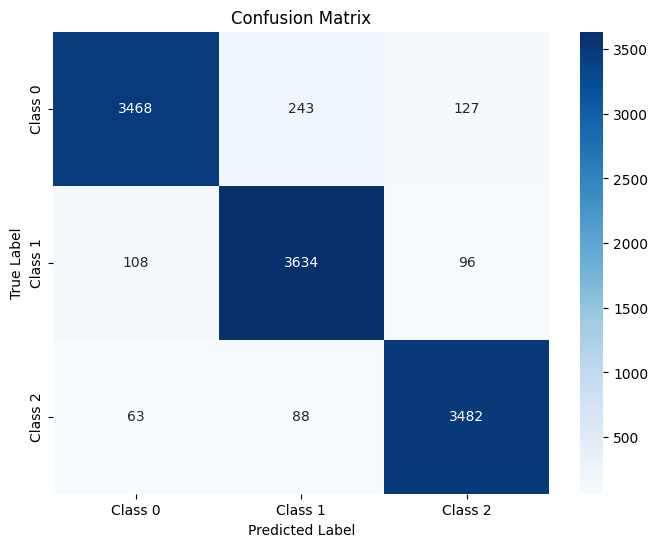

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0) # Adjusted to unpack only loss and accuracy

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test F1 Score: {f1_score_val:.4f}") # Removed f1_score_val from print statement

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 11. Evaluation
Evaluate the model's performance on the test set using accuracy, loss, classification report, and confusion matrix.

In [ ]:
def predict_sentence(sentence):
    # Clean the sentence
    cleaned_sentence = clean_text_with_links(sentence)
    # Lemmatize the sentence
    lemmatized_sentence = lemmatize_text(cleaned_sentence)
    # Tokenize the sentence
    tokenized_sentence = lemmatized_sentence.split()
    # One-hot encode the sentence
    one_hot_sentence = [one_hot(" ".join(tokenized_sentence), vocab_size)]
    # Pad the sequence
    padded_sentence = pad_sequences(
        one_hot_sentence,
        maxlen=max_seq_length,
        padding='pre'
    )
    # Predict the class
    prediction = model.predict(padded_sentence)
    predicted_class = np.argmax(prediction, axis=1)[0]

    class_labels = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}
    return class_labels[predicted_class]

# Test the function with a sample sentence
test_sentence = "i honestly dont suggest the product "
predicted_label = predict_sentence(test_sentence)
print(f"The sentence: '{test_sentence}' is classified as: {predicted_label}")

test_sentence_hate = "I hate this product"
predicted_label_hate = predict_sentence(test_sentence_hate)
print(f"The sentence: '{test_sentence_hate}' is classified as: {predicted_label_hate}")

## 12. Inference
Define a function to predict the class of new, unseen sentences.